In [34]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import Normalize
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm, LinearSegmentedColormap

In [35]:
import visualizer
import dataparser

In [36]:
df = pd.read_csv("QF_S_PARSED.csv")

In [40]:
df["task-clock:u"] = df["task-clock:u"].astype(float)
df

,Unnamed: 0,problem,solver,status,sanity_sat,task-clock:u,context-switches:u,cpu-migrations:u,page-faults:u,cycles:u,...,branches:u,branch-misses:u,slots:u,topdown-retiring:u,topdown-bad-spec:u,topdown-fe-bound:u,topdown-be-bound:u,elapsed,user,sys
0,0,out/benchmarks/non-incremental/QF_S/20240318-o...,z3noodler,Success,unsat,17.51,0.0,0.0,2709.0,3.999192e+07,...,1.629039e+07,178066.0,1.999156e+08,7.823070e+07,1.958755e+07,6.361164e+07,3.992855e+07,0.018525,0.010643,0.007452
1,1,out/benchmarks/non-incremental/QF_S/20240318-o...,cvc5,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,out/benchmarks/non-incremental/QF_S/20240318-o...,ostrich,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,out/benchmarks/non-incremental/QF_S/20240318-o...,z3noodler,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,out/benchmarks/non-incremental/QF_S/20240318-o...,z3alpha,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75755,75755,out/benchmarks/non-incremental/QF_S/2020-sygus...,ostrich,Success,sat,3263.32,0.0,0.0,28995.0,1.005769e+10,...,2.325929e+09,69980513.0,4.524896e+10,8.493112e+09,2.444141e+10,1.021312e+10,1.056403e+10,1.010327,2.927523,0.402496
75756,75756,out/benchmarks/non-incremental/QF_S/2020-sygus...,cvc5,Success,sat,71.74,0.0,0.0,1264.0,2.432433e+08,...,6.818224e+07,1791506.0,1.216192e+09,3.529874e+08,2.336997e+08,4.769694e+08,1.526756e+08,0.073158,0.065992,0.005993
75757,75757,out/benchmarks/non-incremental/QF_S/2020-sygus...,ostrich,Success,sat,2581.70,0.0,0.0,29789.0,7.908598e+09,...,2.104755e+09,65930584.0,3.812858e+10,7.429565e+09,2.546560e+10,9.140415e+09,5.721529e+09,0.958888,2.316515,0.321057
75758,75758,out/benchmarks/non-incremental/QF_S/2020-sygus...,z3alpha,Success,sat,57.85,0.0,0.0,6226.0,1.519642e+08,...,5.163598e+07,1119131.0,7.591048e+08,2.115894e+08,1.646719e+08,2.520233e+08,1.433909e+08,0.066438,0.041962,0.016503


In [41]:
pivot_df = df.pivot(index='problem', columns='solver', values='task-clock:u')

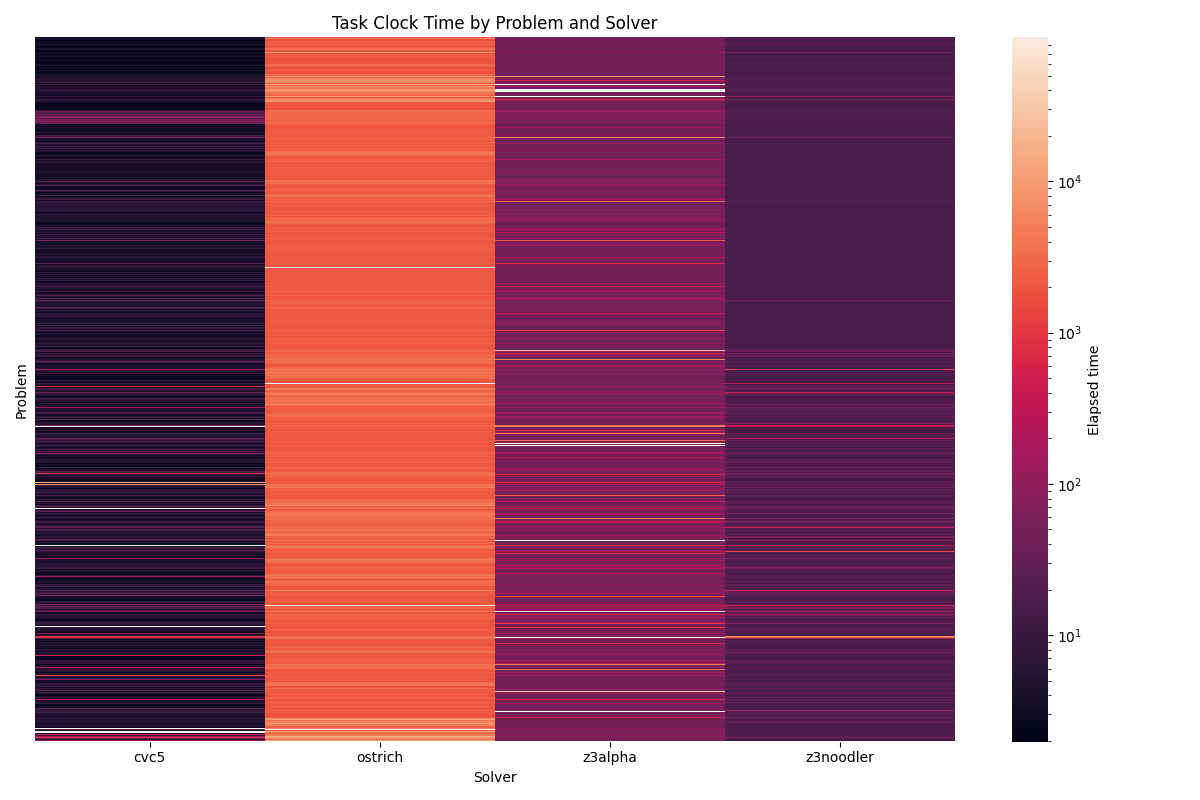

In [42]:
%matplotlib widget


plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_df,
    annot=False,
    fmt=".2f",
    cbar_kws={'label': 'Elapsed time'},
    norm=LogNorm(),
)

# Title and labels
plt.title('Task Clock Time by Problem and Solver')
plt.xlabel('Solver')
plt.ylabel('Problem')

plt.yticks([])
plt.xticks()


plt.tight_layout()

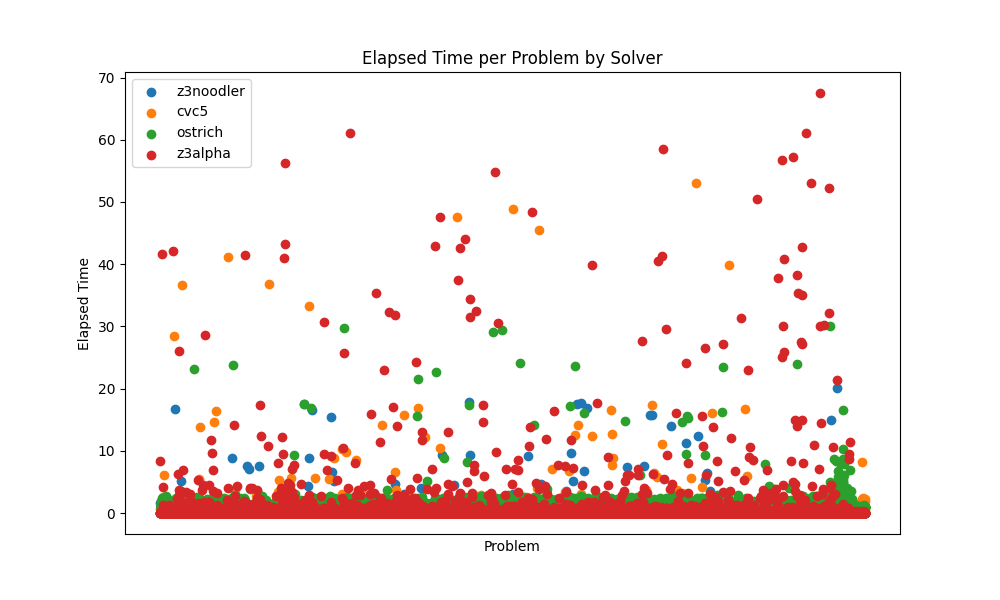

In [43]:
%matplotlib widget
plt.figure(figsize=(10, 6))
for solver in df['solver'].unique():
    subset = df[df['solver'] == solver]
    plt.scatter(subset['problem'], subset['elapsed'], label=solver)

plt.xlabel('Problem')
plt.ylabel('Elapsed Time')
plt.title('Elapsed Time per Problem by Solver')
plt.legend()
plt.xticks([])  # Rotate x-axis labels if they overlap
plt.show()

In [22]:
ostrich = df[df["solver"] == "ostrich"]
cvc = df[df["solver"] == "cvc5"]
noodler = df[df["solver"] == "z3noodler"]
alpha = df[df["solver"] == "z3alpha"]

In [25]:
print(ostrich.shape)
print(cvc.shape)
print(noodler.shape)
print(alpha.shape)

(18940, 21)
(18940, 21)
(18940, 21)
(18940, 21)


In [26]:
reduced_df = df[["solver", "problem", "sanity_sat", "task-clock:u", "elapsed", "status"]]
#reduced_df = reduced_df[reduced_df["elapsed"] < 60]

In [27]:
pivoted = reduced_df.pivot_table(index='problem', columns='solver', values='sanity_sat', aggfunc='first')

In [28]:
pivoted.loc[pivoted.nunique(axis=1) > 1]

solver,cvc5,ostrich,z3alpha,z3noodler
problem,,,,
20230329-automatark-lu_instance10095,sat,sat,Performance counter stats for '/software/pytho...,sat
20230329-automatark-lu_instance13458,unsat,unsat,Performance counter stats for '/software/pytho...,unsat


In [33]:
success = df[df["status"] == "Success"]
success[~success["sanity_sat"].isin(["sat", "unsat"])]

,Unnamed: 0,problem,solver,status,sanity_sat,task-clock:u,context-switches:u,cpu-migrations:u,page-faults:u,cycles:u,...,branches:u,branch-misses:u,slots:u,topdown-retiring:u,topdown-bad-spec:u,topdown-fe-bound:u,topdown-be-bound:u,elapsed,user,sys
826,826,20230329-automatark-lu_instance10095,z3alpha,Success,Performance counter stats for '/software/pytho...,54875.91,0.0,0.0,353811.0,1.947803e+11,...,8.435888e+10,118371370.0,9.723373e+11,2.960952e+11,1.983260e+11,6.394942e+10,4.360905e+11,54.886672,54.173789,0.580751
26184,26184,20230329-automatark-lu_instance13458,z3alpha,Success,Performance counter stats for '/software/pytho...,31349.45,0.0,0.0,66256.0,1.119310e+11,...,3.195671e+10,709146486.0,5.593604e+11,1.199731e+11,2.039956e+11,1.036569e+11,1.678972e+11,31.360989,31.171394,0.078702
